In [1]:
%matplotlib inline
from __future__ import print_function, unicode_literals
import sys, os, glob
import re
import datetime as dt

In [2]:
sys.path.append("../firedetection/")
from pygaarst import raster
import viirstools as vt
import viirsswathtools as vst
import viirsifire as vif

In [3]:
import geopandas as gp
import pandas as pd

In [4]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns

In [5]:
from shapely.geometry import Point, Polygon

In [6]:
reload(vt)
reload(vif)
reload(vst)
reload(raster)

<module 'pygaarst.raster' from '/Users/cwaigl/Dropbox/Research/pygaarst/pygaarst/raster.pyc'>

In [7]:
sns.set(rc={'image.cmap': 'gist_heat'})
sns.set_context("poster")

myfontsize = 20
font = {'family' : 'Calibri',
        'weight': 'bold',
        'size'   : myfontsize}
matplotlib.rc('font', **font)
matplotlib.axes.rcParams['axes.labelsize']=myfontsize-4
matplotlib.axes.rcParams['axes.titlesize']=myfontsize
cmap1 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'canary yellow']))
cmap2 =  matplotlib.colors.ListedColormap(sns.xkcd_palette(['white', 'purplish blue']))

In [8]:
ALT1 = True
ALT2 = False 

basedir = '/Volumes/cwdata1/VIIRS/GINA/dds.gina.alaska.edu/NPP/viirs/'
if ALT1:
    basedir = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/'
elif ALT2:
    basedir = '/Volumes/SCIENCE/Fire/DATA_BY_AREA/2015/VIIRS/'

if os.path.isdir(basedir):
    print(basedir, "exists")
else:
    print("Please check directory {}: cannot access it.".format(basedir))

/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/ exists


Sockeye fire

In [9]:
sockeye_lon, sockeye_lat = (-150.08544, 61.84486)
sample_lon, sample_lat = sockeye_lon, sockeye_lat
deli, delj = (125, 125)

In [10]:
viirsscenes = {    
    u'2015_06_14_165_1148': 4,
    u'2015_06_14_165_2144': 2,
    u'2015_06_14_165_2325': 2,
    u'2015_06_15_166_1130': 4,
    u'2015_06_15_166_2125': 2,
    u'2015_06_15_166_2306': 2,
    u'2015_06_16_167_1111': 4,
    u'2015_06_16_167_1251': 4,
    u'2015_06_16_167_1431': 4,
    u'2015_06_16_167_2107': 3,
    u'2015_06_16_167_2247': 3,
    u'2015_06_17_168_1052': 4,
#    (u'2015_06_17_168_1232', 4,
    u'2015_06_17_168_1413': 4,
    u'2015_06_18_169_1214': 4,
    u'2015_06_18_169_1354': 4,
    u'2015_06_18_169_2209': 3,
    u'2015_06_18_169_2351': 2,
    u'2015_06_19_170_1154': 4,
    u'2015_06_19_170_2011': 2,
    u'2015_06_19_170_2150': 2,
#    (u'', ),
}

Eagle fires

In [15]:
sample_lon, sample_lat = (-141.4, 65.0)
deli, delj = (125, 125)

In [16]:
viirsscenes = {
    u'2015_05_27_147_2042': 3,
    u'2015_05_27_147_2223': 2,
    u'2015_05_28_148_1027': 2,
    u'2015_05_28_148_2024': 2,
    u'2015_05_29_149_2144': 3,
#    u'2015_06_22_173_2054': 3,
}

Yukon-Koyukuk fires test scene

In [19]:
sample_lon, sample_lat = (-153.35, 65.8)
deli, delj = (200, 300)

In [20]:
viirsscenes = {
    u'2015_07_06_187_2131': 2,
}

In [21]:
viirsscenes.keys()

[u'2015_07_06_187_2131']

In [22]:
scenes = vt.getoverpasses(basedir, viirsscenes.keys())
i04paths = {id: os.path.join(scenes[id]['dir'], scenes[id]['SVI04'][viirsscenes[id]]) for id in viirsscenes}
i05paths = {id: os.path.join(scenes[id]['dir'], scenes[id]['SVI05'][viirsscenes[id]]) for id in viirsscenes}

In [23]:
i04paths

{u'2015_07_06_187_2131': u'/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/VIIRS/2015_07_06_187_2131/sdr/SVI04_npp_d20150706_t2136198_e2137439_b19118_c20150706220143967785_cspp_dev.h5'}

In [24]:
IDX = u'2015_07_06_187_2131'

In [25]:
i04file = i04paths[IDX]
i05file = i05paths[IDX]

cbarfraction = 0.05
cbarpad = 0.05

testscene04 = raster.VIIRSHDF5(i04file)
testscene05 = raster.VIIRSHDF5(i05file)
#imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, 200, 300)
imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, deli, delj)
print(vt.getdatestamp_AKDT(testscene04))
print("Ascending: ", testscene04.ascending_node)
print(
    testscene04.lats[testscene04.getnearestidx(sample_lat, sample_lon)], 
    testscene04.lons[testscene04.getnearestidx(sample_lat, sample_lon)]
)
print(sample_lat, sample_lon)
datestamp = vt.getdatestamp_AKDT(testscene04)
pixq4 = testscene04.pixelquality[imin:imax, jmin:jmax]
pixq5 = testscene05.pixelquality[imin:imax, jmin:jmax]
# find row indices where no data present
excluderows = np.where((pixq4[:, 0] == 2) | (pixq4[:, -1] == 2) )
pixq4 = np.delete(pixq4, excluderows, 0)
pixq5 = np.delete(pixq5, excluderows, 0)

2015-07-06 13:36:19 AKDT
Ascending:  True
65.7988 -153.348
65.8 -153.35


### Testing the location and properties of the test granules

In [26]:
for _, i04path in i04paths.items():
    testscene04 = raster.VIIRSHDF5(i04path)
    imin, imax, jmin, jmax = testscene04.crop(sample_lat, sample_lon, deli, delj)
    print(vt.getdatestamp_AKDT(testscene04))
    print("Ascending: ", testscene04.ascending_node)
    print(
        testscene04.lats[testscene04.getnearestidx(sample_lat, sample_lon)], 
        testscene04.lons[testscene04.getnearestidx(sample_lat, sample_lon)]
    )
    print(sample_lat, sample_lon)
    print()

2015-07-06 13:36:19 AKDT
Ascending:  True
65.7988 -153.348
65.8 -153.35



In [27]:
vst.is_nightscene(testscene04, imin=0, imax=None, jmin=0, jmax=None)

False

In [28]:
testscene04.ascending_node

True

In [29]:
testscene04.meta

{u'Data_Product': {u'AggregateBeginningDate': u'20150706',
  u'AggregateBeginningGranuleID': u'NPP001168905804',
  u'AggregateBeginningOrbitNumber': u'19118',
  u'AggregateBeginningTime': u'213619.803439Z',
  u'AggregateEndingDate': u'20150706',
  u'AggregateEndingGranuleID': u'NPP001168905804',
  u'AggregateEndingOrbitNumber': u'19118',
  u'AggregateEndingTime': u'213743.979035Z',
  u'Instrument_Short_Name': u'VIIRS',
  u'N_Collection_Short_Name': u'VIIRS-I4-SDR',
  u'N_Dataset_Type_Tag': u'SDR',
  u'N_Processing_Domain': u'OPS'},
 u'Distributor': u'cspp',
 u'Mission_Name': u'NPP',
 u'N_Dataset_Source': u'all-',
 u'N_GEO_Ref': u'GITCO_npp_d20150706_t2136198_e2137439_b19118_c20150706220141848799_cspp_dev.h5',
 u'N_HDF_Creation_Date': u'20150706',
 u'N_HDF_Creation_Time': u'220143.967785Z',
 u'Number_of_Data_Products': u'1',
 u'Platform_Short_Name': u'NPP'}

In [30]:
vt.get_date_UTC(testscene04), vt.get_time_UTC(testscene04)

('2015-07-06', '2136')

In [31]:
rasterlist = []
excluderows

(array([  8,   9,  10,  11,  40,  41,  42,  43,  72,  73,  74,  75, 104,
        105, 106, 107, 136, 137, 138, 139, 168, 169, 170, 171, 200, 201,
        202, 203, 232, 233, 234, 235, 264, 265, 266, 267, 296, 297, 298,
        299, 328, 329, 330, 331, 360, 361, 362, 363, 392, 393, 394, 395]),)

## Calculate cells with at duplicate locations

In [32]:
skips = vst.get_skips(testscene04, imin=imin, imax=imax, jmin=jmin, jmax=jmax)

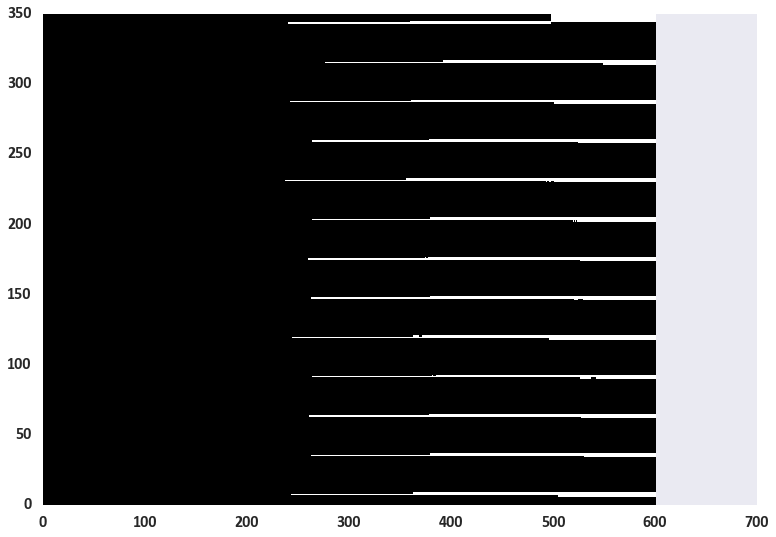

In [33]:
plt.pcolormesh(np.delete(skips, excluderows, 0))

In [34]:
skiprows = vst.get_badrows(skips)
skiprows

array([  6,   7,   8,   9,  10,  11,  12,  38,  39,  40,  41,  42,  43,
        44,  70,  71,  72,  73,  74,  75,  76, 102, 103, 104, 105, 106,
       107, 108, 134, 135, 136, 137, 138, 139, 140, 166, 167, 168, 169,
       170, 171, 172, 198, 199, 200, 201, 202, 203, 204, 230, 231, 232,
       233, 234, 235, 236, 262, 263, 264, 265, 266, 267, 268, 294, 295,
       296, 297, 298, 299, 300, 326, 327, 328, 329, 330, 331, 332, 358,
       359, 360, 361, 362, 363, 364, 391, 392, 393, 394, 395, 396, 397,
       398, 399, 400])

## Get fire pixels

In [35]:
platform = np.array([], dtype='|S10')
sensor = np.array([], dtype='|S10')
bands = np.array([], dtype='|S10')
acdate = np.array([], dtype='|S10')
gmt = np.array([], dtype='|S4')
hotspottype = np.array([], dtype='|S1')
ascnode = np.array([], dtype='|S1')
lat = np.array([], dtype='|f4')
lon = np.array([], dtype='|f4')
tb4 = np.array([], dtype='|f4')
tb5 = np.array([], dtype='|f4')
solarzenithangle = np.array([], dtype='|f4')
sensorzenithangle = np.array([], dtype='|f4')

pointgeom = []
polygeom = []

hotspottypes = ['A', 'H', 'L']

totals = [0, 0, 0]
for sceneid in i04paths:

    i4sc = raster.VIIRSHDF5(i04paths[sceneid])
    i5sc = raster.VIIRSHDF5(i05paths[sceneid])
    imin, imax, jmin, jmax = i4sc.crop(sample_lat, sample_lon, deli, delj)

    skips = vst.get_skips(i4sc, imin=imin, imax=imax, jmin=jmin, jmax=jmax)
    skiprows = vst.get_badrows(skips)

#    lons = np.delete(i4sc.lons[imin:imax, jmin:jmax], skiprows, 0)
#    lats = np.delete(i4sc.lats[imin:imax, jmin:jmax], skiprows, 0)
    lons = i4sc.lons[imin:imax, jmin:jmax]
    lats = i4sc.lats[imin:imax, jmin:jmax]


    mult, add = i4sc.I4['BrightnessTemperatureFactors'][:]
    i4tb = i4sc.I4['BrightnessTemperature'][imin:imax, jmin:jmax]
    i4tb = i4tb * mult + add
    mult, add = i5sc.I5['BrightnessTemperatureFactors'][:]
    i5tb = i5sc.I5['BrightnessTemperature'][imin:imax, jmin:jmax]
    i5tb = i5tb * mult + add

    pixq4 = i4sc.pixelquality[imin:imax, jmin:jmax]
    pixq5 = i5sc.pixelquality[imin:imax, jmin:jmax]

    #i4tb = np.delete(i4tb, skiprows, 0)
    #i5tb = np.delete(i5tb, skiprows, 0)
    #pixq4 = np.delete(pixq4, skiprows, 0)
    #pixq5 = np.delete(pixq5, skiprows, 0)

    datestamp = vt.getdatestamp_AKDT(i4sc)

    nightscene = True
#    solzenithangles = np.delete(i4sc.geodata['SolarZenithAngle'][imin:imax, jmin:jmax], skiprows, 0)
#    satzenithangles = np.delete(i4sc.geodata['SatelliteZenithAngle'][imin:imax, jmin:jmax], skiprows, 0)
    solzenithangles = i4sc.geodata['SolarZenithAngle'][imin:imax, jmin:jmax]
    satzenithangles = i4sc.geodata['SatelliteZenithAngle'][imin:imax, jmin:jmax]
    if np.all(solzenithangles <= 90.):
        nightscene = False
    elif (np.any(solzenithangles > 90.) & np.any(solzenithangles <= 90.)):
        print("WARNING: mixed scene with zenith angles above and below 90°.")

    i45 =  (i4tb - i5tb) / (i4tb + i5tb)
    datestamp = vt.getdatestamp_AKDT(i4sc)

    duplicatecondition = (skips == 1.)
    anom, hot, warm = vif.getfireconditions_fromrasters(
        i4tb, i5tb, pixq4, pixq5, ~nightscene)
    for cond in [anom, hot, warm]:
        print('duplicates: ', sum(sum(np.logical_and(duplicatecondition, cond))))
        #cond = np.logical_and(cond, ~duplicatecondition)
    anom = np.logical_and(anom, ~duplicatecondition)
    hot = np.logical_and(hot, ~duplicatecondition)
    warm = np.logical_and(warm, ~duplicatecondition)

    totals[0] += sum(sum(anom))
    totals[1] += sum(sum(hot))
    totals[2] += sum(sum(warm))
    print(datestamp)    
    print(np.where(anom))
    print(np.where(hot))
    print(np.where(warm))
    print()
    
    dt = vt.get_date_UTC(i4sc)
    tm = vt.get_time_UTC(i4sc)
    asc = 'Y' if i4sc.ascending_node else 'N'
    for cond, condtype in zip([anom, hot, warm], hotspottypes):
        N = sum(sum(cond))
        if N > 0:
            platform = np.concatenate([platform, np.repeat(['NPP'], N)])
            sensor = np.concatenate([sensor, np.repeat(['VIIRS'], N)])
            bands = np.concatenate([bands, np.repeat(['I-Bands'], N)])
            acdate = np.concatenate([acdate, np.repeat([dt], N)])
            gmt = np.concatenate([gmt, np.repeat([tm], N)])
            hotspottype = np.concatenate([hotspottype, np.repeat([condtype], N)])
            ascnode = np.concatenate([ascnode, np.repeat([asc], N)])
            lat = np.concatenate([lat, lats[np.where(cond)]])
            lon = np.concatenate([lon, lons[np.where(cond)]])
            tb4 = np.concatenate([tb4, i4tb[np.where(cond)]])
            tb5 = np.concatenate([tb5, i5tb[np.where(cond)]])
            solarzenithangle = np.concatenate([solarzenithangle, solzenithangles[np.where(cond)]])
            sensorzenithangle = np.concatenate([sensorzenithangle, satzenithangles[np.where(cond)]])
            pointgeom.extend([Point(llo, lla) 
                        for llo, lla in zip(lons[np.where(cond)], lats[np.where(cond)])])
            polygeom.extend([Polygon(vst.get_corners_wgs_from_latlon(ii, jj, lons, lats))  
                        for ii, jj in np.dstack(np.where(cond))[0]])

print(totals)
print(sum(totals))

duplicates:  6
duplicates:  81
duplicates:  134
2015-07-06 13:36:19 AKDT
(array([ 35,  71,  71, 109, 122, 122, 126, 128, 132, 133, 133, 134, 190,
       208, 212, 213, 214, 214, 214, 215, 215, 215, 216, 216, 216, 216,
       216, 217, 221, 225, 228, 242, 251, 258, 291, 301, 303, 303, 304,
       307, 308, 312, 312, 313, 315, 319, 319, 324, 336, 339, 339, 339,
       340, 341, 341, 341, 342, 342, 342, 342, 343, 343, 343, 343, 344,
       344, 344, 345, 345]), array([259, 122, 123, 236, 523, 524, 116, 129, 133, 122, 126, 123, 304,
       310, 306, 306, 295, 304, 307, 304, 307, 308, 304, 305, 306, 307,
       308, 307, 246, 247, 269, 232, 270, 254, 342, 346, 345, 346, 347,
       345, 345, 337, 338, 338, 323, 332, 334, 376, 376, 366, 367, 372,
       369, 369, 371, 375, 370, 373, 375, 378, 372, 373, 374, 375, 373,
       374, 375, 374, 376]))
(array([ 14,  14,  15,  15,  15,  15,  16,  16,  16,  16,  16,  17,  17,
        17,  17,  17,  17,  18,  18,  18,  19,  20,  21,  22,  22,  22,
   

In [36]:
basedf = pd.DataFrame({
        'Platform': platform,
        'Sensor': sensor,
        'Bands': bands,
        'DATE': acdate,
        'GMT': gmt,
        'Type': hotspottype,
        'AscNode': ascnode,
        'LAT': lat,
        'LON': lon,
        'TB4': tb4,
        'TB5': tb5,
        'SolZenithAng': solarzenithangle,
        'SatZenithAng': sensorzenithangle
    })

In [37]:
basedf

,AscNode,Bands,DATE,GMT,LAT,LON,Platform,SatZenithAng,Sensor,SolZenithAng,TB4,TB5,Type
0,Y,I-Bands,2015-07-06,2136,65.439606,-152.213028,NPP,32.051739,VIIRS,43.211994,367.000000,299.111969,A
1,Y,I-Bands,2015-07-06,2136,65.862053,-151.052811,NPP,27.754086,VIIRS,43.528515,367.000000,310.424713,A
2,Y,I-Bands,2015-07-06,2136,65.860077,-151.061188,NPP,27.784838,VIIRS,43.527222,367.000000,310.091248,A
3,Y,I-Bands,2015-07-06,2136,65.692650,-152.295959,NPP,31.324392,VIIRS,43.464497,367.000000,304.696381,A
4,Y,I-Bands,2015-07-06,2136,65.061653,-154.906403,NPP,39.144943,VIIRS,43.122398,367.000000,297.381531,A
5,Y,I-Bands,2015-07-06,2136,65.059784,-154.913071,NPP,39.166157,VIIRS,43.121391,367.000000,308.652161,A
6,Y,I-Bands,2015-07-06,2136,66.027336,-151.228851,NPP,27.561676,VIIRS,43.703262,367.000000,301.670776,A
7,Y,I-Bands,2015-07-06,2136,66.004860,-151.360275,NPP,27.967619,VIIRS,43.691483,367.000000,305.496643,A
8,Y,I-Bands,2015-07-06,2136,66.008705,-151.417023,NPP,28.093557,VIIRS,43.699749,367.000000,306.402222,A
9,Y,I-Bands,2015-07-06,2136,66.036209,-151.319122,NPP,27.751022,VIIRS,43.719009,367.000000,306.321533,A


In [38]:
crs = {'init': 'epsg:4326', 'no_defs': True}
pointDF = gp.GeoDataFrame(basedf.copy(), crs=crs, geometry=pointgeom)
polygonDF = gp.GeoDataFrame(basedf.copy(), crs=crs, geometry=polygeom)

In [39]:
pointDF.shape

(1535, 14)

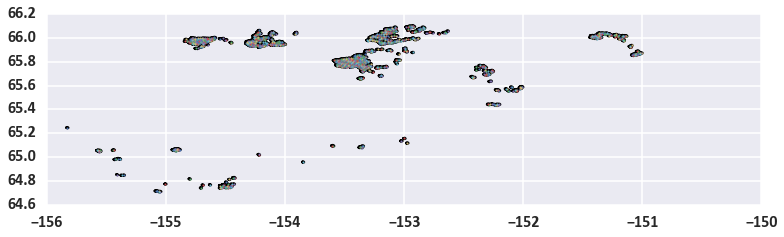

In [40]:
polygonDF.plot()
pointDF.plot()

In [43]:
polygonDF[polygonDF['LAT'] < 61.7]

,AscNode,Bands,DATE,GMT,LAT,LON,Platform,SatZenithAng,Sensor,SolZenithAng,TB4,TB5,Type,geometry


In [42]:
gisout = '/Volumes/SCIENCE_mobile_Mac/Fire/DATA_BY_PROJECT/2015VIIRSMODIS/GISout/'

In [43]:
polygonDF.to_file(os.path.join(gisout, 'WesternAKviirsspoly_20160719.shp'))